# What is this notebook about
This notebook is meant to be run first, to explore the dataset

> Please ensure you have downloaded the necessary data first from the <a href="https://spacenet.ai/spacenet-roads-dataset/">SpaceNet 3 Website</a> for AOI 3 (Paris)

# Setup and Imports

In [1]:
import os
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt


import fiona
import rasterio
from rasterio.plot import show as show_raster
from rasterio.mask import mask

Setup the file structures 

# Global Variables

In [2]:
ROOT_DIR = Path('')
PATH_DATA = ROOT_DIR/'data'

if not os.path.exists('data/train'):
    os.makedirs('data/train')
if not os.path.exists('data/test'):
    os.makedirs('data/test')
    
PATH_TRAIN_SRC = PATH_DATA/'AOI_3_Paris'
PATH_TEST_SRC = PATH_DATA/'AOI_3_Paris_Roads_Test_Public'    
PATH_TRAIN = PATH_DATA/'train'    
PATH_TEST = PATH_DATA/'test'    

In [3]:
# And index, used just for inspecting one specific file
INSPECT_IDX = 3

# Helper Functions

### inspect_tif(tif_file)
Used to check out the basic features of a given tif file

In [4]:
def inspect_tif(tif_file):
    print("Count: {}".format(tif_file.count))

    # check the geospatial boundary of this image file, the corners of the image
    print("Corners: {}".format(tif_file.bounds))

    # getting dimensions, in map units of meters
    width = tif_file.bounds.right - tif_file.bounds.left
    height = tif_file.bounds.top - tif_file.bounds.bottom
    print("Width: {}, Height: {}".format(width, height))

    # getting pixel dimensions
    width_px = tif_file.width
    height_px = tif_file.height
    print("Pixels - Width: {}, Height: {}".format(width_px, height_px))

    # how many meters to a pixel
    width_ratio = width/width_px
    height_ratio = height/height_px
    print("m to px Ratio - Width: {}, Height: {}".format(width_ratio, height_ratio))

    # get coordinate reference system
    print("Coordinate Reference System: {}".format(tif_file.crs))

    # Get coordinates of top left and bottom right points since there is a coordinate reference system attached to this file
    topleft = tif_file.transform * (0,0)
    bottomright = tif_file.transform * (width, height)

    print("Top left coordinates: {}, Bottom right coordinates: {}".format(topleft, bottomright))

    # get basic metadata of this geotif file
    print("Metadata of geotiff file")
    print(tif_file.meta)     # can also use satdat.profile instead of satdat.meta

    # get number of bands by listing indices. count in the metadata refers to the number of bands
    print("Indexes: {}".format(tif_file.indexes))

In [5]:
def plot_bands(raster):
    channels = raster.read().shape[0]
    
    # PAN
    if channels == 1:
        show_raster(raster)
    
    # RGB
    elif channels == 3:
        fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
        show_raster((raster, 1), ax=axr, cmap='Reds', title='red channel')
        show_raster((raster, 2), ax=axg, cmap='Greens', title='green channel')
        show_raster((raster, 3), ax=axb, cmap='Blues', title='blue channel')
        plt.show()
    
    # Multispectral
    elif channels == 8:
        fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9)) = plt.subplots(3,3, figsize=(21,21))
        show_raster((raster, 1), ax=ax1, cmap='Reds', title='channel 1')
        show_raster((raster, 2), ax=ax2, cmap='Greens', title='channel 2')
        show_raster((raster, 3), ax=ax3, cmap='Blues', title='channel 3')
        show_raster((raster, 4), ax=ax4, cmap='Reds', title='channel 4')
        show_raster((raster, 5), ax=ax5, cmap='Greens', title='channel 5')
        show_raster((raster, 6), ax=ax6, cmap='Blues', title='channel 6')
        show_raster((raster, 7), ax=ax7, cmap='Reds', title='channel 7')
        show_raster((raster, 8), ax=ax8, cmap='Greens', title='channel 8')
        plt.show()      
        
    else:
        print("Wrong format")

# Data Inspection

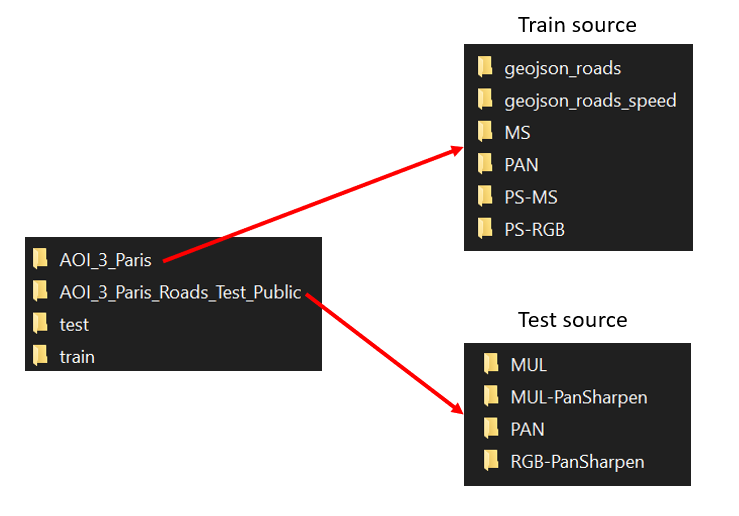

<b>Data Directory</b>

The image above shows the data directory. We will have to pre-process all of the data before we can start working with them

* AOI_3_Paris
    * This folder houses the training data
* AOI_3_Paris_Roads_Test_Public
    * This folder houses the testing data. We are not provided the geojson files for this

<br>
<b>Key Terminologies</b>

There are several key terminologies that we will need

* geojson
    * geojson files contain spatial information about a picture, since as latitude, longitude, spatial dimensions, camera angle etc., and can also contain polygon data that are used to draw a mask over certain areas in the image 
* MS / MUL
    * These refer to Multi-Spectral images, which are images that have several bands corresponding to several ranges of the electromagnetic spectrum (e.g. radio, optical, microwave)
* PAN
    * These refer to Panchromatic images, which are images that have only one band typically represented in greyscale. These are images captured using the entirety of the EM spectrum, which effectively captures the absolute intensity of light. Hence they are very high resolution images that have a great level of detail
* RGB
    * These refer to Red-Green-Blue images, which is the typical optical image that we have in our day-to-day life. They only use the visible spectrum of light
* PS / PanSharpen XXX
    * These refer to an amalgamation of PAN images with another image type (XXX) in order to enhance the resolution of other images while retaining their band-specific data

Henceforth we will use the terms `geojson, ms, pan, rgb, ps` 

### Take a look at the files in every relevant folder

In [6]:
train_src_geojson_roads_fnames = next(os.walk(PATH_TRAIN_SRC/'geojson_roads'))[2]
print("length of train_src_geojson_roads_fnames:", len(train_src_geojson_roads_fnames))
train_src_geojson_roads_fnames[:3]

length of train_src_geojson_roads_fnames: 257


['SN3_roads_train_AOI_3_Paris_geojson_roads_img10.geojson',
 'SN3_roads_train_AOI_3_Paris_geojson_roads_img100.geojson',
 'SN3_roads_train_AOI_3_Paris_geojson_roads_img101.geojson']

In [7]:
train_src_geojson_roads_speed_fnames = next(os.walk(PATH_TRAIN_SRC/'geojson_roads_speed'))[2]
print("length of train_src_geojson_roads_speed_fnames:", len(train_src_geojson_roads_speed_fnames))
train_src_geojson_roads_speed_fnames[:3]

length of train_src_geojson_roads_speed_fnames: 258


['road_speed_estimates.txt',
 'SN3_roads_train_AOI_3_Paris_geojson_roads_speed_img10.geojson',
 'SN3_roads_train_AOI_3_Paris_geojson_roads_speed_img100.geojson']

In [8]:
train_src_ms_fnames = next(os.walk(PATH_TRAIN_SRC/'MS'))[2]
print("length of train_src_ms_fnames:", len(train_src_ms_fnames))

train_src_pan_fnames = next(os.walk(PATH_TRAIN_SRC/'PAN'))[2]
print("length of train_src_pan_fnames:", len(train_src_pan_fnames))

train_src_psms_fnames = next(os.walk(PATH_TRAIN_SRC/'PS-MS'))[2]
print("length of train_src_psms_fnames:", len(train_src_psms_fnames))

train_src_psrgb_fnames = next(os.walk(PATH_TRAIN_SRC/'PS-RGB'))[2]
print("length of train_src_psrgb_fnames:", len(train_src_psrgb_fnames))

length of train_src_ms_fnames: 311
length of train_src_pan_fnames: 310
length of train_src_psms_fnames: 311
length of train_src_psrgb_fnames: 310


In [9]:
test_src_ms_fnames = next(os.walk(PATH_TEST_SRC/'MUL'))[2]
print("length of test_src_ms_fnames:", len(test_src_ms_fnames))

test_src_psms_fnames = next(os.walk(PATH_TEST_SRC/'MUL-PanSharpen'))[2]
print("length of test_src_ms_fnames:", len(test_src_psms_fnames))

test_src_pan_fnames = next(os.walk(PATH_TEST_SRC/'PAN'))[2]
print("length of test_src_pan_fnames:", len(test_src_pan_fnames))

test_src_psrgb_fnames = next(os.walk(PATH_TEST_SRC/'RGB-PanSharpen'))[2]
print("length of test_src_psrgb_fnames:", len(test_src_psrgb_fnames))

length of test_src_ms_fnames: 104
length of test_src_ms_fnames: 104
length of test_src_pan_fnames: 104
length of test_src_psrgb_fnames: 104


In [10]:
# Drop some unwanted file names
del train_src_geojson_roads_speed_fnames[0]
del train_src_ms_fnames[0]
del train_src_psms_fnames[0]

print("length of train_src_geojson_roads_speed_fnames:", len(train_src_geojson_roads_speed_fnames))
print("length of train_src_ms_fnames:", len(train_src_ms_fnames))
print("length of train_src_psms_fnames:", len(train_src_psms_fnames))

length of train_src_geojson_roads_speed_fnames: 257
length of train_src_ms_fnames: 310
length of train_src_psms_fnames: 310


### Inspect train_src_geojson_roads files

In [11]:
sample_train_src_geojson_roads = fiona.open(PATH_TRAIN_SRC/'geojson_roads'/train_src_geojson_roads_fnames[INSPECT_IDX]) 
for feature in sample_train_src_geojson_roads: 
    print(feature)
    print("")

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('bridge_typ', '2'), ('heading', '0'), ('lane_numbe', '2'), ('lane_number', '2'), ('one_way_ty', '2'), ('paved', '1'), ('road_id', 254), ('road_type', '5'), ('origarea', 0), ('origlen', 0.00648708481388674), ('partialDec', 1), ('truncated', 0)]), 'geometry': {'type': 'LineString', 'coordinates': [(2.23452853552, 49.02582715702), (2.2350835976, 49.02567442525), (2.23548156741, 49.02553321015), (2.23582305118, 49.02550839053), (2.23617908439, 49.02549983204), (2.23641701042, 49.02545875129), (2.2366399591, 49.0253509143), (2.23668992977, 49.02532572025), (2.23675763835, 49.02529271657), (2.23717186929, 49.02510614148), (2.23730639995, 49.02504762814408)]}}

{'type': 'Feature', 'id': '1', 'properties': OrderedDict([('bridge_typ', '2'), ('heading', '0'), ('lane_numbe', '1'), ('lane_number', '1'), ('one_way_ty', '2'), ('paved', '1'), ('road_id', 1221), ('road_type', '5'), ('origarea', 0), ('origlen', 0.0035267172342883517), ('partial

> We can see that every element in a geojson_roads file represents a specific physical feature 

In [12]:
sample_train_src_geojson_roads[INSPECT_IDX]

{'type': 'Feature',
 'id': '3',
 'properties': OrderedDict([('bridge_typ', '2'),
              ('heading', '0'),
              ('lane_numbe', '2'),
              ('lane_number', '2'),
              ('one_way_ty', '2'),
              ('paved', '1'),
              ('road_id', 629),
              ('road_type', '5'),
              ('origarea', 0),
              ('origlen', 0.0018826273932640398),
              ('partialDec', 1),
              ('truncated', 0)]),
 'geometry': {'type': 'LineString',
  'coordinates': [(2.23484652741, 49.02495979129),
   (2.235040384294363, 49.0248909)]}}

> The `geometry` property will allow us to create a segmentation mask over the original image

### Inspect train_src_geojson_roads_speed files

In [13]:
sample_train_src_geojson_roads_speed = fiona.open(PATH_TRAIN_SRC/'geojson_roads_speed'/train_src_geojson_roads_speed_fnames[INSPECT_IDX]) 
for feature in sample_train_src_geojson_roads_speed: 
    print(feature)
    print("")

{'type': 'Feature', 'id': '0', 'properties': OrderedDict([('heading', '0'), ('lane_number', '2'), ('one_way_ty', '2'), ('paved', '1'), ('road_id', 254), ('road_type', '5'), ('origarea', 0), ('origlen', 0.00648708481388674), ('partialDec', 1), ('truncated', 0), ('bridge_type', '2'), ('inferred_speed_mph', 25), ('inferred_speed_mps', 11.176)]), 'geometry': {'type': 'LineString', 'coordinates': [(2.23452853552, 49.02582715702), (2.2350835976, 49.02567442525), (2.23548156741, 49.02553321015), (2.23582305118, 49.02550839053), (2.23617908439, 49.02549983204), (2.23641701042, 49.02545875129), (2.2366399591, 49.0253509143), (2.23668992977, 49.02532572025), (2.23675763835, 49.02529271657), (2.23717186929, 49.02510614148), (2.23730639995, 49.02504762814408)]}}

{'type': 'Feature', 'id': '1', 'properties': OrderedDict([('heading', '0'), ('lane_number', '1'), ('one_way_ty', '2'), ('paved', '1'), ('road_id', 1221), ('road_type', '5'), ('origarea', 0), ('origlen', 0.0035267172342883517), ('partialDe

In [14]:
sample_train_src_geojson_roads_speed[INSPECT_IDX]

{'type': 'Feature',
 'id': '3',
 'properties': OrderedDict([('heading', '0'),
              ('lane_number', '2'),
              ('one_way_ty', '2'),
              ('paved', '1'),
              ('road_id', 629),
              ('road_type', '5'),
              ('origarea', 0),
              ('origlen', 0.0018826273932640398),
              ('partialDec', 1),
              ('truncated', 0),
              ('bridge_type', '2'),
              ('inferred_speed_mph', 25),
              ('inferred_speed_mps', 11.176)]),
 'geometry': {'type': 'LineString',
  'coordinates': [(2.23484652741, 49.02495979129),
   (2.235040384294363, 49.0248909)]}}

> The difference is the inclusion of `inferred_speed_mph` and `inferred_speed_mps` for this road feature

### Inspect train_src_MS files

In [15]:
sample_train_src_ms = rasterio.open(PATH_TRAIN_SRC/'MS'/train_src_ms_fnames[INSPECT_IDX])
inspect_tif(sample_train_src_ms)

Count: 8
Corners: BoundingBox(left=2.23379639995, bottom=49.0248909, right=2.23730639995, top=49.0284009)
Width: 0.003509999999999902, Height: 0.00350999999999857
Pixels - Width: 325, Height: 325
m to px Ratio - Width: 1.0799999999999698e-05, Height: 1.0799999999995599e-05
Coordinate Reference System: EPSG:4326
Top left coordinates: (2.23379639995, 49.0284009), Bottom right coordinates: (2.233796437858, 49.028400862092)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 325, 'height': 325, 'count': 8, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(1.0799999999999698e-05, 0.0, 2.23379639995,
       0.0, -1.0799999999995599e-05, 49.0284009)}
Indexes: (1, 2, 3, 4, 5, 6, 7, 8)


> We get a detailed print out of the information embedded in the tif file. We can see that the multispectral images have 8 channels, as given by the `indexes`

### Inspect train_src_PAN files

In [16]:
sample_train_src_pan = rasterio.open(PATH_TRAIN_SRC/'PAN'/train_src_pan_fnames[INSPECT_IDX])
inspect_tif(sample_train_src_pan)

Count: 1
Corners: BoundingBox(left=2.23379639995, bottom=49.0248909, right=2.23730639995, top=49.0284009)
Width: 0.003509999999999902, Height: 0.00350999999999857
Pixels - Width: 1300, Height: 1300
m to px Ratio - Width: 2.6999999999999246e-06, Height: 2.6999999999988997e-06
Coordinate Reference System: EPSG:4326
Top left coordinates: (2.23379639995, 49.0284009), Bottom right coordinates: (2.233796409427, 49.028400890523)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1300, 'height': 1300, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.6999999999999246e-06, 0.0, 2.23379639995,
       0.0, -2.6999999999988997e-06, 49.0284009)}
Indexes: (1,)


> Similarly, we get a print of the details for a PAN image, which as we expect has 1 channel. <br>We also note the increased pixel count - 1300x1300 for PAN versus 325x325 for MS

### Inspect train_src_PS-MS files

In [17]:
sample_train_src_psms = rasterio.open(PATH_TRAIN_SRC/'PS-MS'/train_src_psms_fnames[INSPECT_IDX])
inspect_tif(sample_train_src_psms)

Count: 8
Corners: BoundingBox(left=2.23379639995, bottom=49.0248909, right=2.23730639995, top=49.0284009)
Width: 0.003509999999999902, Height: 0.00350999999999857
Pixels - Width: 1300, Height: 1300
m to px Ratio - Width: 2.6999999999999246e-06, Height: 2.6999999999988997e-06
Coordinate Reference System: EPSG:4326
Top left coordinates: (2.23379639995, 49.0284009), Bottom right coordinates: (2.233796409427, 49.028400890523)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1300, 'height': 1300, 'count': 8, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.6999999999999246e-06, 0.0, 2.23379639995,
       0.0, -2.6999999999988997e-06, 49.0284009)}
Indexes: (1, 2, 3, 4, 5, 6, 7, 8)


> We observe that the PS-MS image has 8 channels, and also the higher resolution by pixel count (1300x1300)

### Inspect train_src_PS-RGB files

In [18]:
sample_train_src_psrgb = rasterio.open(PATH_TRAIN_SRC/'PS-RGB'/train_src_psrgb_fnames[INSPECT_IDX])
inspect_tif(sample_train_src_psrgb)

Count: 3
Corners: BoundingBox(left=2.23379639995, bottom=49.0248909, right=2.23730639995, top=49.0284009)
Width: 0.003509999999999902, Height: 0.00350999999999857
Pixels - Width: 1300, Height: 1300
m to px Ratio - Width: 2.6999999999999246e-06, Height: 2.6999999999988997e-06
Coordinate Reference System: EPSG:4326
Top left coordinates: (2.23379639995, 49.0284009), Bottom right coordinates: (2.233796409427, 49.028400890523)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1300, 'height': 1300, 'count': 3, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.6999999999999246e-06, 0.0, 2.23379639995,
       0.0, -2.6999999999988997e-06, 49.0284009)}
Indexes: (1, 2, 3)


> We see the RGB channel has three channels by the three indexes, and also that it has a 1300x1300 resolution due to pan sharpening

### Inspect test_src_MUL files

In [19]:
sample_test_src_ms = rasterio.open(PATH_TEST_SRC/'MUL'/test_src_ms_fnames[INSPECT_IDX])
inspect_tif(sample_test_src_ms)

Count: 8
Corners: BoundingBox(left=2.23730639995, bottom=49.0319109, right=2.24081639995, top=49.0354209)
Width: 0.003509999999999902, Height: 0.00350999999999857
Pixels - Width: 325, Height: 325
m to px Ratio - Width: 1.0799999999999698e-05, Height: 1.0799999999995599e-05
Coordinate Reference System: EPSG:4326
Top left coordinates: (2.23730639995, 49.0354209), Bottom right coordinates: (2.237306437858, 49.035420862091996)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 325, 'height': 325, 'count': 8, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(1.0799999999999698e-05, 0.0, 2.23730639995,
       0.0, -1.0799999999995599e-05, 49.0354209)}
Indexes: (1, 2, 3, 4, 5, 6, 7, 8)


### Inspect test_src_MUL-PanSharpen

In [20]:
sample_test_src_psms = rasterio.open(PATH_TEST_SRC/'MUL-PanSharpen'/test_src_psms_fnames[INSPECT_IDX])
inspect_tif(sample_test_src_psms)

Count: 8
Corners: BoundingBox(left=2.23730639995, bottom=49.0319109, right=2.24081639995, top=49.0354209)
Width: 0.003509999999999902, Height: 0.00350999999999857
Pixels - Width: 1300, Height: 1300
m to px Ratio - Width: 2.6999999999999246e-06, Height: 2.6999999999988997e-06
Coordinate Reference System: EPSG:4326
Top left coordinates: (2.23730639995, 49.0354209), Bottom right coordinates: (2.237306409427, 49.035420890523)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1300, 'height': 1300, 'count': 8, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.6999999999999246e-06, 0.0, 2.23730639995,
       0.0, -2.6999999999988997e-06, 49.0354209)}
Indexes: (1, 2, 3, 4, 5, 6, 7, 8)


### Inspect test_src_PAN

In [21]:
sample_test_src_pan = rasterio.open(PATH_TEST_SRC/'PAN'/test_src_pan_fnames[INSPECT_IDX])
inspect_tif(sample_test_src_pan)

Count: 1
Corners: BoundingBox(left=2.23730639995, bottom=49.0319109, right=2.24081639995, top=49.0354209)
Width: 0.003509999999999902, Height: 0.00350999999999857
Pixels - Width: 1300, Height: 1300
m to px Ratio - Width: 2.6999999999999246e-06, Height: 2.6999999999988997e-06
Coordinate Reference System: EPSG:4326
Top left coordinates: (2.23730639995, 49.0354209), Bottom right coordinates: (2.237306409427, 49.035420890523)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1300, 'height': 1300, 'count': 1, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.6999999999999246e-06, 0.0, 2.23730639995,
       0.0, -2.6999999999988997e-06, 49.0354209)}
Indexes: (1,)


### Inspect test_src_RGB-PanSharpen

In [22]:
sample_test_src_psrgb = rasterio.open(PATH_TEST_SRC/'RGB-PanSharpen'/test_src_psrgb_fnames[INSPECT_IDX])
inspect_tif(sample_test_src_psrgb)

Count: 3
Corners: BoundingBox(left=2.23730639995, bottom=49.0319109, right=2.24081639995, top=49.0354209)
Width: 0.003509999999999902, Height: 0.00350999999999857
Pixels - Width: 1300, Height: 1300
m to px Ratio - Width: 2.6999999999999246e-06, Height: 2.6999999999988997e-06
Coordinate Reference System: EPSG:4326
Top left coordinates: (2.23730639995, 49.0354209), Bottom right coordinates: (2.237306409427, 49.035420890523)
Metadata of geotiff file
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 1300, 'height': 1300, 'count': 3, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(2.6999999999999246e-06, 0.0, 2.23730639995,
       0.0, -2.6999999999988997e-06, 49.0354209)}
Indexes: (1, 2, 3)


# Let's take a peek at the images

### Notes about the tif files

In [23]:
print("Type of the file read by rasterio.open():", type(sample_test_src_psrgb))

print("Access raw image pixel values through: rasterfile.read()")

print("Type of the raw image pixel values:", type(sample_test_src_psrgb.read()))

print("Shape of the raw image pixel values:", sample_test_src_psrgb.read().shape)

Type of the file read by rasterio.open(): <class 'rasterio.io.DatasetReader'>
Access raw image pixel values through: rasterfile.read()
Type of the raw image pixel values: <class 'numpy.ndarray'>
Shape of the raw image pixel values: (3, 1300, 1300)


### Very important note
Pay attention to the shape of the pixels: it is in the format `(channels, height, width)`. However, RGB images are conventionally represented as `(height, width, channels)`

> Raster format: `(channels, height, width)`

> Normal format: `(height, width, channels)`

We need to remember to do reshaping in order to use conventional ML tools that are trained on regular images

### View an image
We have imported `show` from rasterio as `show_raster`. This is a wrapper on matplotlib that accepts a raster format of `(channels, height, width)` and plots it out. However it can only accept up to a 3 channel raster image

##### Single channel PAN image

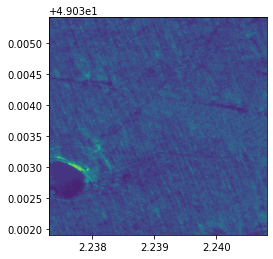

<AxesSubplot:>

In [24]:
show_raster(sample_test_src_pan)

##### Three channel psrgb image

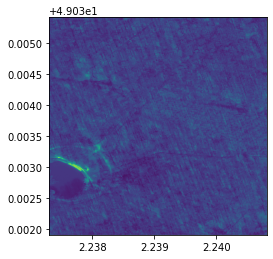

<AxesSubplot:>

In [25]:
show_raster(sample_test_src_psrgb)

### Encompass raster plotting functionalities in a helper function plot_bands()

##### We can plot a PAN image

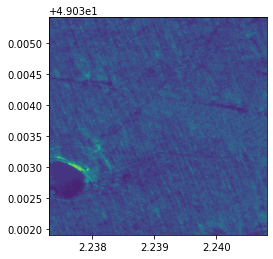

In [26]:
plot_bands(sample_test_src_pan)

##### We can unpack the individual channels of a RGB image

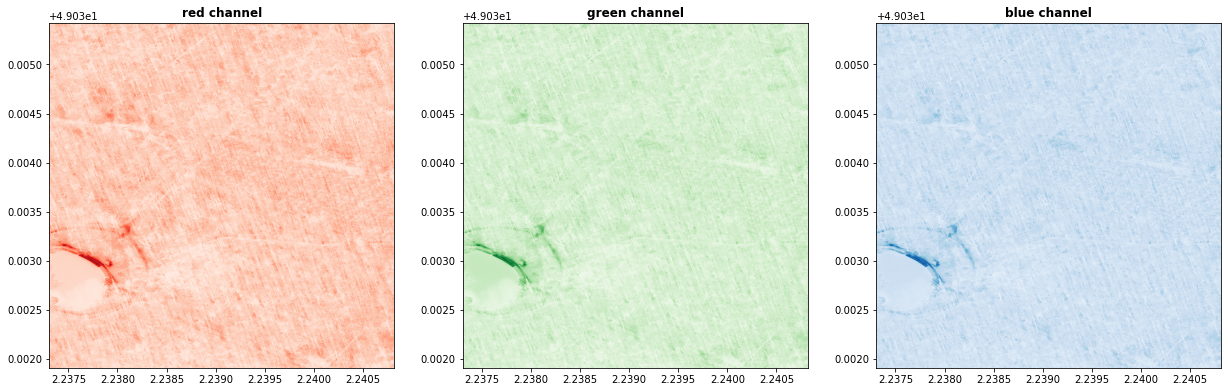

In [27]:
plot_bands(sample_test_src_psrgb)

##### We can also unpack all 8 channels of a MS image

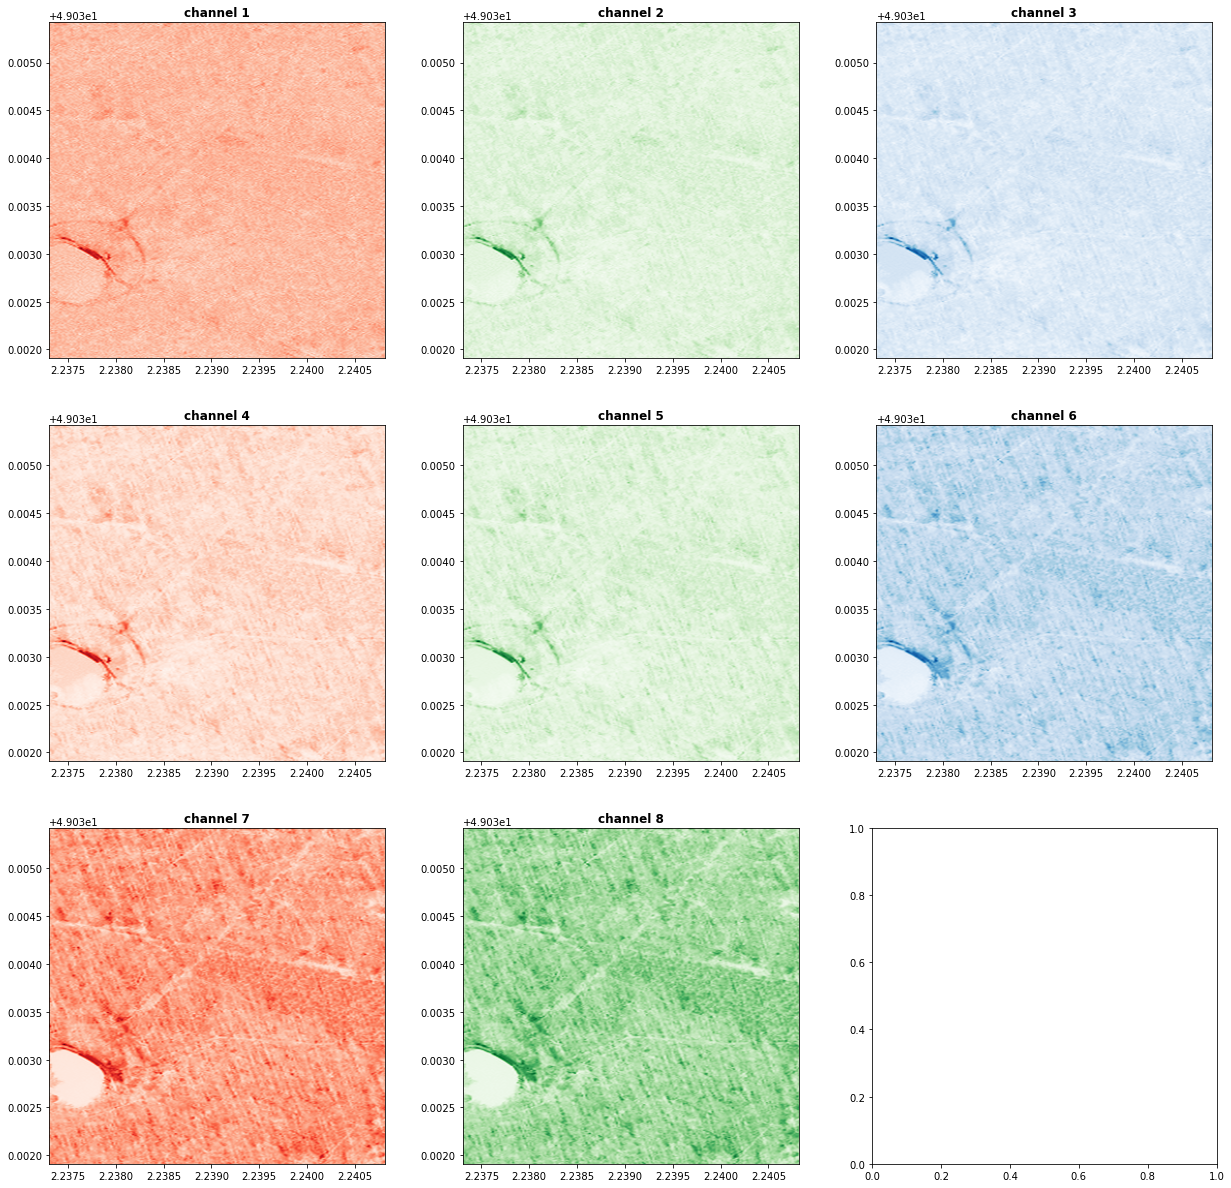

In [28]:
plot_bands(sample_test_src_ms)

# We've inspected the data, now what?

We can utilise utility files provided by the dataset creator to generate our training masks over the images. The utility files can be found from <a href="https://github.com/CosmiQ/apls">CosmiQ's GitHub repository</a>.

It has been cloned into our project folder